# Marketing Campaign Optimization
Tony Blonigan

### Contents

1. [Business Objective](#bo)
2. [Data Analysis](#da)
3. [Predictive Modeling](#ps)
4. [Strategic plan](#sp)
5. [Next Steps](#ns)
6. [Appendix](#a)

<a id='bo'></a>
# Business Objective

## Background
Springleaf is a personal leanding company that provides subprime loans people can use to purchase consumer goods. The company wishes to imporove its direct mail marketing campaign and has published [this](https://www.kaggle.com/c/springleaf-marketing-response/data) dataset for research. The goal of this project is not to simply create a predictive model that will increase the company's conversion rate, from a baseline of 23%, but also to illustrate a comprehensive marketing strategy and the value it can deliver to the company.

- Data
  - 145.2K rows
  - 1934 columns
    - 1882 columns are numeric
    - 51 columns are categorical
  - The column called 'target' indicates whether the opportunity was converted
- Objective
  - Improve promotional targeting
  - Increase conversion rate from baseline of 23%
  - Optimize profit through comprehensive marketing strategy

### Notes
- While I stuck to the data in building and evaluating models, some of the background is based off of unchecked assumptions. The point of this notebook is to illustrate how to leverage data to drive business objectives, not simply build predictive models. A business context makes this a much easier read, so I embelished some details that were not covered in the materials related to the original [dataset](https://www.kaggle.com/c/springleaf-marketing-response/data).
- Since the point of this is to illustrate a business case, I took some shortcuts with the model building, for example, I assumed all columns pandas interpreted as numeric were non-categorical; and I didn't check for outliers in any columns.


## Current Strategy
Currently, the company is using domain knowledge of in-house marketers to target broad market segments based on high-level, demographic indicators. For example, they know their conversion rate is higher among users in the North East (N.E.), so they send promotional literature to everyone in the N.E., on their client list. We can understand this as a crude method of propensity scoring (P.S.), where a higher P.S. corresponds to a higher probability of conversion. In this example people in the N.E. would have a higher P.S. than, say, people in the Mid-West.

We can visualize group of N.E. clients by representing each individual as a dot, where its P.S. represented by darkness of the dot (the higher the P.S., the darker the dot).

In [1]:
# import packages
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from scipy.stats import entropy
import warnings

# modeling libraries
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import SelectPercentile, f_classif, VarianceThreshold
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer

# THIS SECTION JUST LOADS DATA, SETS DATA TYPES, AND MAKES SURE NA VALUES ARE np.nan
# read data if its not already loaded
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    try:
        df
    except NameError:
        df = pd.read_csv('data/train.csv.zip')
    
# convert boolean columns to dtype of boolean
bool_cols = []
for c in df.select_dtypes(include='object').columns:
    vals = df[c].value_counts().index
    
    if (True in vals) | (False in vals):
        df[c] = df[c].astype(bool).astype(int)
        bool_cols.append(c)
        
# convert datetime cols from object to datetime
dt_tm_cols = ['VAR_0073',
 'VAR_0075',
 'VAR_0156',
 'VAR_0157',
 'VAR_0158',
 'VAR_0159',
 'VAR_0166',
 'VAR_0167',
 'VAR_0168',
 'VAR_0169',
 'VAR_0176',
 'VAR_0177',
 'VAR_0178',
 'VAR_0179',
 'VAR_0204',
 'VAR_0217']

for c in dt_tm_cols:
    df[c] = pd.to_datetime(df[c], format="%d%b%y:%H:%M:%S")

# format string cols (treating state and city as string, treating -1 or blank as na)
loc_cols = ['VAR_0237',
 'VAR_0274',
 'VAR_0200']

str_cols = ['VAR_0001',
 'VAR_0005',
 'VAR_0044',
 'VAR_0202',
 'VAR_0216',
 'VAR_0222',
 'VAR_0283',
 'VAR_0305',
 'VAR_0325',
 'VAR_0342',
 'VAR_0352',
 'VAR_0353',
 'VAR_0354',
 'VAR_0404',
 'VAR_0466',
 'VAR_0467',
 'VAR_0493',
 'VAR_1934',
 'VAR_0214']

# convert na vals to np.na
for c in str_cols + loc_cols:
    msk = (df[c] == '-1') | df[c].isna()
    df.loc[msk, c] = np.nan

num_cols = [c for c in df.select_dtypes(exclude='object').columns 
            if c not in ['ID', 'target'] + str_cols + loc_cols + dt_tm_cols]

# train test split
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['ID', 'target']), 
                                                    df[['target']], 
                                                    test_size=0.33, random_state=1, 
                                                    shuffle=True, stratify=df[['target']])

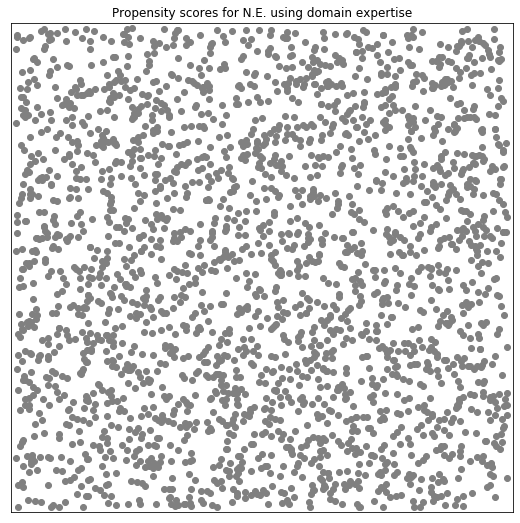

In [2]:
# create market strategy visualizations for presentation
np.random.seed(1)


# setup data for illustrations of current v future strategy
# vector of probs for n representitive samples (sorted by p, ascending)
n = 2500
p = np.random.uniform(0, 1, n)
p = np.sort(p)
y_loc = np.random.uniform(0, 1, n)
# shuffled index
idx_shuffled = np.random.choice(np.arange(n), n, replace=False)

# plot current scoring illustration
fig, ax = plt.subplots(figsize=(9, 9))
plt.scatter(p[idx_shuffled], y_loc, color='grey')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.xlim(-.01, 1.01)
plt.ylim(-.01, 1.01)
plt.title('Propensity scores for N.E. using domain expertise')
plt.show()

## Improved Propensity Scoring
As you can see in the plot above, while using coarse, demographic data to target customers is a good start to optimizing marketing campaigns, the resulting scores are not very precise. It would be much better if we could score each individual, but this becomes an untractable amount of work for domain experts to do. Better to automate this using machine learning.

To illustrate this idea, lets imagine what the scores machine learning could generate and think through the consequences.

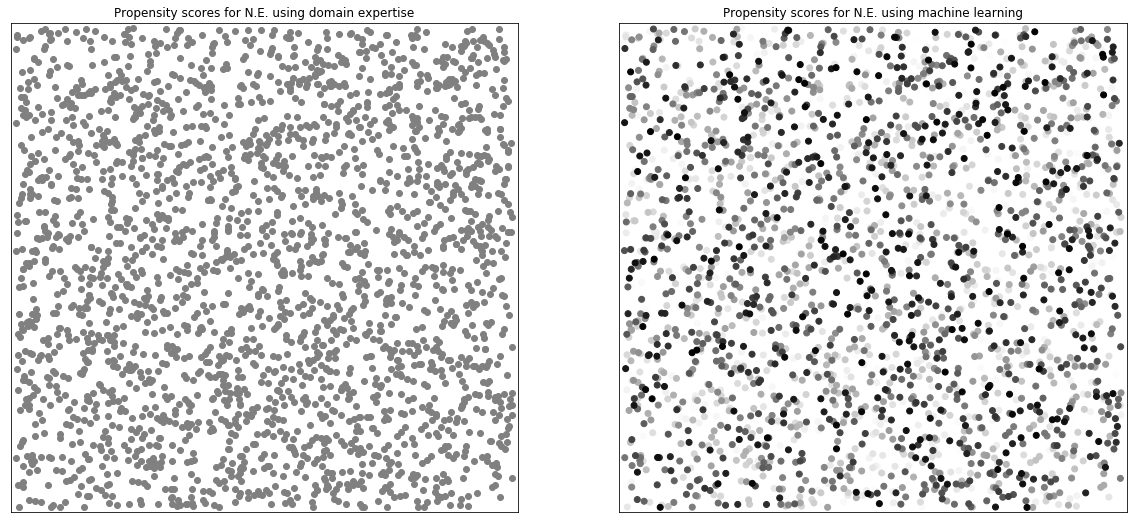

In [3]:
# plot future scoring illustration
fig, ax = plt.subplots(1, 2, figsize=(20, 9))
ax[0].scatter(p[idx_shuffled], y_loc, color='grey')
ax[1].scatter(p[idx_shuffled], y_loc, c=p, cmap='Greys')
for i in range(2):
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].set_xlim(-.01, 1.01)
    ax[i].set_ylim(-.01, 1.01)
ax[0].set_title('Propensity scores for N.E. using domain expertise')
ax[1].set_title('Propensity scores for N.E. using machine learning')

plt.show()

As illustrated above, using domain experts to set marketing targets resluts in a crude approximation of conversion propensity. This can be explained mostly by two limitations:
- It is difficult for humans to pull patterns out of a dataset with ~2k columns, leading to oversimplifications of the problem
- It is time consuming/expensive for humans to review each potential client before determining their propensity score

Fortunately, machine learning easily overcomes both of these limitations, allowing us to calculate much more precise propensity scores, like the ones in the right-hand chart above.

## Bennefits
As we will demonstrate later on, more precise propensity scores will allow us to:
1. Reduce marketing costs by limiting promotional materials being sent to customers who will not convert, and
2. Maintaine revenue generation by continuing to send promotional materials to customers who will convert.

To the extent that we are lowering costs faster than we are reducing revenue generation, we will increase both ROI and profit.

<a id='da'></a>
# Data Analysis
Before we can realize these bennefits we have to train a model to score our customers. To illustrate the way our model will use the data in scoring customers, lets visualize some of the columns' relationships to the target varible.

## Numeric Correlations
We have a lot of columns with minor correlations to whether a marketing target will convert. While none of them have a high enough correlation with the outcome to be usefull predictions on their own, we are going to hope that the model can use a set of weak correlations to assign usefull propensity scores.

The plot below shows the conversion probabilty of a customer (y axis), given the value of the most correlated numeric variable: `VAR_0105` (x axis). As you can see, the conversion probability increases, as `VAR_0105` increases.

Remember that we had a baseline conversion rate of 23% using traditional targeting strategies. On the plot, the dashed line shows this starting point. Even with just a single, weakly correlated variable, we are already starting to see how we can develop a more precise understanding of our customers. For example, the 20% of customers with `VAR_0105 > 0` are more likely to convert than the general population. The machine learning application will take this into account when scoring candidates for promotional literature.

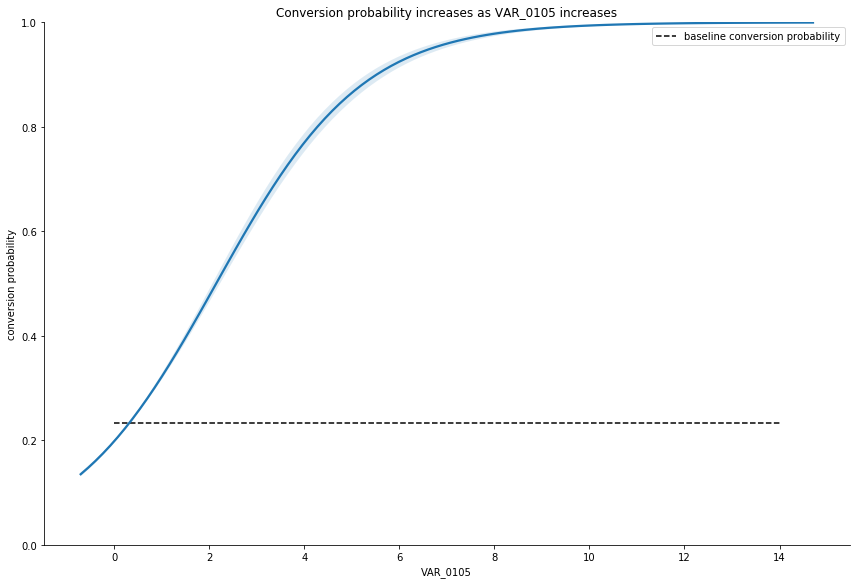

In [11]:
col_corr_cols = []
col_corr = []

for c in num_cols:
    # ignore nans
    msk = ~np.isnan(x_train_num[c])
    
    # surpress a bunch of undefined value warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        this_cor = np.corrcoef(x_train.loc[msk, c], y_train.loc[msk, 'target'])[0][1]
    
    if np.isnan(this_cor):
        continue
    else:
        col_corr_cols.append(c)
        col_corr.append(this_cor)

# find most correlated column
col_corr = np.array(col_corr)

# find 
idx_max = np.argmax(np.abs(col_corr))
c = col_corr_cols[idx_max]

p_naive = y_train.target.value_counts()[1] / len(y_train)

sns_df = pd.concat((x_train, y_train), axis=1)
sns.lmplot(c,'target', data=sns_df, 
           logistic=True, scatter=False, height=8, aspect=12/8)
plt.hlines(p_naive, min(x_train[c]), max(x_train[c]), linestyles='--', 
           label='baseline conversion probability')
plt.ylim(0, 1)
plt.title(f'Conversion probability increases as {c} increases')
plt.ylabel(f'conversion probability')
plt.legend()
plt.show()

del sns_df

## Categorical Information
As with numeric data, the model can use categorical data to inform propensity scores. The plot below is similar to the one above, but instead of a numeric x axis, the x axis shows discreet values the variable can take. As with the numeric plot above, we have a black, dotted line indicating our baseline, 23% conversion rate. The distance between the top of the bars and the dotted line corresponds to increased precision from our baseline estimation. For example, the 8% of targets in the `CSC` group are much less likely to convert than the overall population.

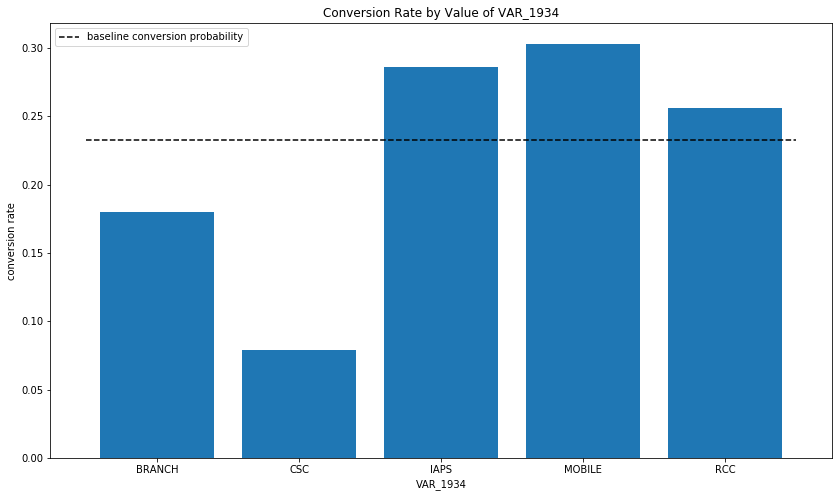

In [12]:
def system_entropy_given_col(split_col, y, na_strategy=None):
    """
    Calculate system entropy after splitting on categories in column 'split_col'
    :param split_col: np.array of column with categories
    :param y: np.array of column with data we are using to check entropy
    :param na_strategy: str, 'fill' or 'drop'
    """
    if na_strategy == 'fill':
        try:
            np.isnan(split_col)
        except TypeError:
            msk = x_train[c].isna()
        
        split_col = split_col.copy()

        split_col[msk] = 'na_unknown_na'
    elif na_strategy == 'drop':
        try:
            np.isnan(split_col)
        except TypeError:
            msk = x_train[c].isna()
            
        split_col = split_col.copy()[msk]

        y = y.copy()[msk]
    else:
        raise Exception("specify na_strategy as either 'fill' or 'drop'")
    # get levels and counts of obs in each level
    lvl, n = np.unique(split_col, return_counts=True)
    
    # calculate entropy for each level, after splitting
    e = []
    for l, ln in zip(lvl, n):
        y_lvls, y_counts = np.unique(y[split_col == l], return_counts=True)

        e.append(entropy(y_counts / y_counts.sum()))
    
    # calculate weighted avg entropy
    return np.average(e, weights=n)

# get data frame of categorical vars to run through and pick out one with a illustrative pattern
x_train_cat = x_train.select_dtypes(include='object')

# find entropy after splitting on each column
col_entropy_cols = []
col_entropy = []

for c in x_train_cat.columns:
    try:
        unique_lvls = np.unique(x_train_cat[c])
    except TypeError:
        # we are just trying to get an example here, so we can ignore errors
#         print(f'skipping {c}, TypeError')
        continue

    # ignore columns with tons of categories
    n_unique = len(unique_lvls)
    
    if n_unique > 15:
#         print(f'skipping {c}, has {n_unique} levels')
        continue
    
    # calculate remaining system entropy, after splitting on col
    this_entropy = system_entropy_given_col(split_col=x_train_cat[c], y=y_train, na_strategy='fill')
    # normalize by number of unique levels
    this_entropy /= len(unique_lvls)

    col_entropy_cols.append(c)
    col_entropy.append(this_entropy)

# find column producing least entropy
col_entropy = np.array(col_entropy)
idx_min = np.argmin(col_entropy)
c = col_entropy_cols[idx_min]

# create bar plot of conversion probability by attribute value
# calculate conversion probability by att val
p = y_train.join(x_train[[c]]).groupby(c).agg(['count', 'sum'])
p.columns = [c[1] for c in p.columns]
p['p'] = p['sum'] / p['count']

# plot conversion prob by att val
fig, ax = plt.subplots(figsize=(14, 8))
plt.bar(p.index.values, p.p)
p_naive = y_train.target.value_counts()[1] / len(y_train)
plt.hlines(p_naive, -.5, len(p) - .5, linestyles='--', 
           label='baseline conversion probability')
plt.legend()
plt.title(f'Conversion Rate by Value of {c}')
plt.ylabel('conversion rate')
plt.xlabel(c)
plt.show()

<a id='ps'></a>
# Propensity Scoring

As we mentioned above, we want to build a machine learning model that can do a more percise job in propensity scoring than the humans who are currently performing the task. The current process assumes all customers have the 23% conversion rate we have realized from our previous campaigns. Now lets use the Random Forest model I built to score customers our model has never seen.

The plot below shows the conversion propensity scores assigned to each of the potential customers. Think of it as taking a coin for each customer (yellow if they converted, and blue if they didn't), and using the propensity score to pile them up along the x-axis. As you can see, the customers who converted tend to have higher propensity scores than those who didn't. The more separated these two piles (yellow and blue) are, the more useful our propensity score is.

Since the non-converting customers have a more tightly grouped mound, with a greater proportion of scores below the dashed line, we can tell that the model is better at evaluating customers who do not convert. This is good, it means we will be able to lower mailing costs by not sending promotions to customers with low scores.

In [19]:
# if retrain set to False, will try to load model from pickle file
# instead of training
retrain = False

# define feature preprocessors
num_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(weights='distance', add_indicator=True))])

cat_transformer = Pipeline(steps=[
    ('simpleimputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehotencoder', OneHotEncoder(handle_unknown='ignore'))])

# consolidate preprocessors
preprocess = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols + bool_cols),
        ('cat', cat_transformer, str_cols + loc_cols)])
#         ('cat', cat_transformer, bool_cols + str_cols + loc_cols)])

# create classification pipeline
pipe = Pipeline(steps=[('preprocess', preprocess),
                       ('variance_threashold', VarianceThreshold()),
                       ('feature_selection', SelectPercentile(score_func=f_classif)),
                       ('clf', RandomForestClassifier(random_state=1, class_weight='balanced'))])

# define hyper parameters to validate
param_grid = [{'preprocess__num__imputer__n_neighbors': [15],
               'feature_selection__percentile': [25, 30],
               'clf__n_estimators': [1500, 2000],
               'clf__max_depth': [5],
               'clf__max_features': [60, 90]}]

# make sure you don't have cv in memory already
try:
    del cv
except NameError:
    pass

if not retrain:
    # try loading file instead of training so you can come back to this without having
    # to re-train the model each time
    try:
        cv = pickle.load(open('random_forest_cv.pickle', 'rb'))
    except FileNotFoundError:
        pass
        
# if wasn't loaded above, train from scratch
try:
    cv
except NameError:
    # k-fold cross-validate
    cv = GridSearchCV(pipe, param_grid, scoring='f1_macro', 
                      refit=True, cv=3, verbose=0)
    train_start = datetime.datetime.now()
    msk = np.random.choice([True, False], len(x_train), p=[.02, .98])
    cv.fit(x_train[msk], y_train[msk].values.ravel())
    print('validation time: {}'.format(datetime.datetime.now() - train_start))

# store model & results
pickle.dump(cv.best_estimator_, open('random_forest.pickle', 'wb'))
pickle.dump(cv, open('random_forest_cv.pickle', 'wb'))

# get subset of test set to speed up processing (this is just an example)
msk_test = np.random.choice([True, False], len(x_test), p=[.2, .8])
y_hat_test = cv.best_estimator_.predict(x_test[msk_test])
y_hat_test_prob = cv.best_estimator_.predict_proba(x_test[msk_test])[:, 1]

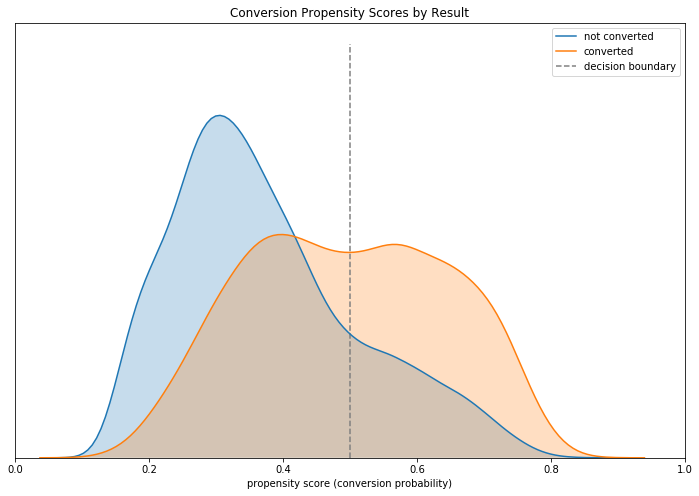

In [22]:
# define a couple of helper functions for model evaluation
def prob_to_y_hat(probs, threashold):
    """
    convert probability vector to binary prediction using threshold as cutoff point
    :param probs: numpy array of probabilities that each observation is positive class ('yes')
    :param threashold: float threashold above which observations will be classified as positive class ('yes')
    :return: numpy array converted to labels {'no', 'yes'}
    """
    # figure out which observations should be yes at threashold
    msk_positive_class = probs >= threashold
    
    # convert probs to labels
    return np.array(['yes' if p else 'no' for p in msk_positive_class])

def decision_function_to_y_hat(dec_funs, threashold):
    """
    convert probability vector to binary prediction using threshold as cutoff point
    :param probs: numpy array of probabilities that each observation is positive class ('yes')
    :param threashold: float threashold above which observations will be classified as positive class ('yes')
    :return: numpy array converted to labels {'no', 'yes'}
    """
    # figure out which observations should be yes at threashold
    msk_positive_class = dec_funs >= threashold
    
    # convert probs to labels
    return np.array(['yes' if p else 'no' for p in msk_positive_class])

p = y_test[msk_test].copy()
p['y_hat'] = y_hat_test_prob

fig, ax = plt.subplots(figsize=(12, 8))
plt.vlines(.5, 0, 4, linestyle='dashed', color='grey', label='decision boundary')
for v in p.target.unique():
    msk_v = p['target'] == v
    sns.kdeplot(p.loc[msk_v, 'y_hat'], label='converted' if v == 1 else 'not converted', shade=True)
plt.xlim(0, 1)
plt.xlabel('propensity score (conversion probability)')
ax.get_yaxis().set_visible(False)
plt.title('Conversion Propensity Scores by Result')
plt.show()

## Strategy



Assumed cost to per mailer: $5
Assumed revenue per conversino: $25
Assumed addressable market size: 47,927

Optimal spend: $25,000
Optimal revenue: $41,625
Optimal profit: $16,625


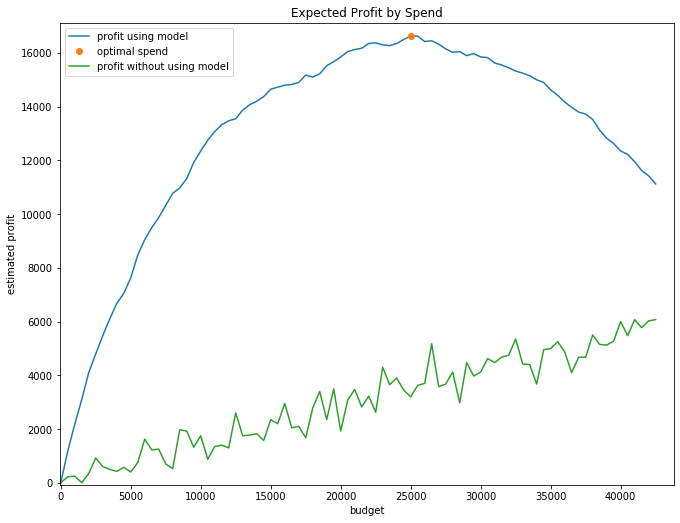

In [60]:
def estimate_profit(spend_per_attempt, revenue_per_success, budget, y_true, y_hat_prob):
    """
    Estimate profit with predictive model, given a specified budget
    
    :param spend_per_attempt: float, avg cost to take action for each individual
    :param revenue_per_success: avg revenue generated by each success
    :param budget: float, budget allocated for attempts
    :param y_true: pd.dataframe with column y (str) containing the actual outcomes
    :param y_hat_prob: np.array with floats of predicted probability 
    each obs is positive class (yes), must be in same order as y_true
    """
    # filter to most likely candidates
    n = budget // spend_per_attempt
    
    # make copy to not alter original data frame
    y_true = y_true.copy()
    y_true['p'] = y_hat_prob
    
    y_true = y_true.sort_values('p', ascending=False).head(n)
    
    # calculate profit
    actual_spend = n * spend_per_attempt
    
    actual_revenue = ((y_true['target'] == 1) * revenue_per_success).sum()
    
    return actual_revenue - actual_spend

def estimate_naive_profit(spend_per_attempt, revenue_per_success, budget, y_true):
    """
    Estimate profit without predictive model, given a specified budget
    
    :param spend_per_attempt: float, avg cost to take action for each individual
    :param revenue_per_success: avg revenue generated by each success
    :param budget: float, budget allocated for attempts
    :param y_true: pd.dataframe with column y (str) containing the actual outcomes
    each obs is positive class (yes), must be in same order as y_true
    """
    # filter to most likely candidates
    n = budget // spend_per_attempt
    
    # make copy to not alter original data frame
    y_true = y_true.copy()
    y_true = np.random.choice(y_true.values.ravel(), n, replace=False)
    
    # calculate profit
    actual_spend = n * spend_per_attempt
    
    actual_revenue = ((y_true == 1) * revenue_per_success).sum()
    
    return actual_revenue - actual_spend

# plot profit by budget
# set spend per attempt and revenue per success assumptions
spa = 5
rps = 25

budget = []
profit = []
naive_profit = []

# estimate profit by budget
for b in np.arange(0, len(y_test)-5000, 500):
    # estimate profit
    est_profit = estimate_profit(spend_per_attempt=spa, revenue_per_success=rps,
                                budget=b, y_true=y_test[msk], y_hat_prob=y_hat_test_prob)
    
    est_naive_profit = estimate_naive_profit(spend_per_attempt=spa, revenue_per_success=rps,
                                budget=b, y_true=y_test[msk])

    # store results for plotting
    budget.append(b)
    profit.append(est_profit)
    naive_profit.append(est_naive_profit)

# calculate optimal spend and profit
max_profit = np.max(np.array(profit))
msk_max_profit = np.array(profit) == max_profit
idx_optimal = np.where(msk_max_profit)[0][0]
optimal_spend = budget[idx_optimal]
optimal_profit = profit[idx_optimal]


print(f'Assumed cost to per mailer: ${spa}')
print(f'Assumed revenue per conversino: ${rps}')
print(f'Assumed addressable market size: {len(y_test):,}', end='\n\n')
print(f'Optimal spend: ${optimal_spend:,}')
print(f'Optimal revenue: ${optimal_spend + optimal_profit:,}')
print(f'Optimal profit: ${optimal_profit:,}')

# plot the results at each threashold & add optimal spend
fig, ax = plt.subplots(figsize=(11, 8.5))
plt.plot(budget, profit, label='profit using model')
plt.plot(optimal_spend, optimal_profit, 'o', label='optimal spend')
plt.plot(budget, naive_profit, label='profit without using model')
# plt.hlines(0, min(budget) + 100, max(budget) - 100)
plt.xlim(-75, b * 1.03)
plt.ylim(-75, optimal_profit * 1.03)
plt.title('Expected Profit by Spend')
plt.ylabel('estimated profit')
plt.xlabel('budget')
plt.legend()
plt.show()

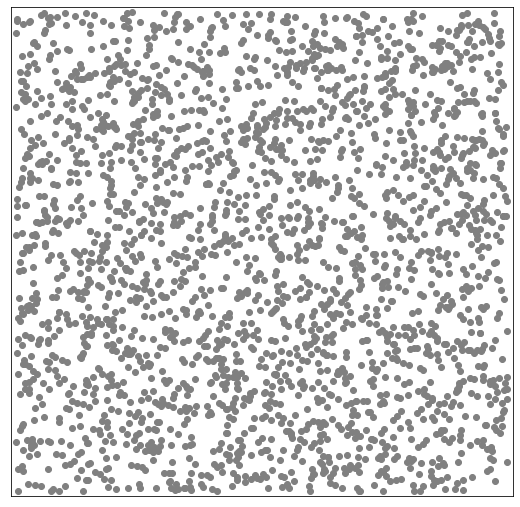

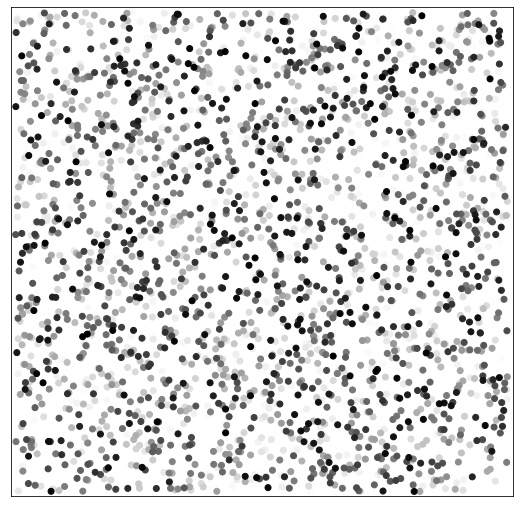

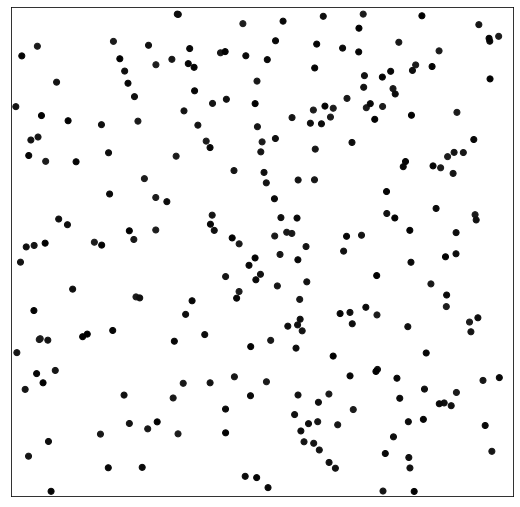

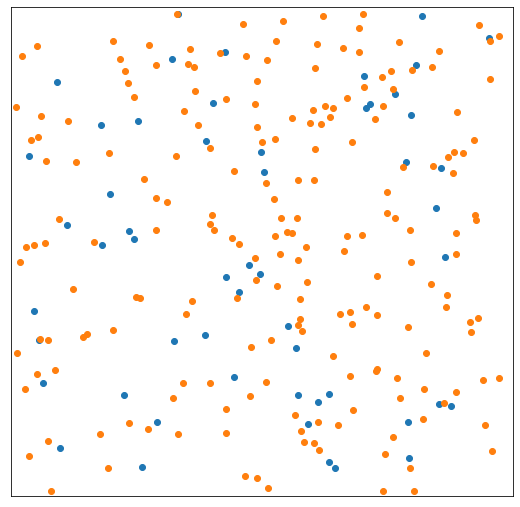

In [28]:
# plot future scoring illustration
fig, ax = plt.subplots(2, 2, figsize=(20, 18))
ax[0].scatter(p[idx_shuffled], y_loc, color='grey')
ax[1].scatter(p[idx_shuffled], y_loc, c=p, cmap='Greys')
ax[2].scatter(p[idx_shuffled], y_loc, c=p, cmap='Greys')
ax[3].scatter(p[idx_shuffled], y_loc, c=p, cmap='Greys')
for i in range(4):
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].set_xlim(-.01, 1.01)
    ax[i].set_ylim(-.01, 1.01)
ax[0].set_title('Propensity scores for N.E. using domain expertise')
ax[1].set_title('Propensity scores for N.E. using machine learning')
ax[2].set_title('Propensity scores for N.E. using machine learning')
ax[3].set_title('Propensity scores for N.E. using machine learning')

plt.show()



# create market strategy visualizations for presentation
np.random.seed(1)

# vector of probs for n representitive samples (sorted by p, ascending)
n = 2500
p = np.random.uniform(0, 100, n)
p = np.sort(p)

y_loc = np.random.uniform(0, 100, n)

# shuffled index
idx_shuffled = np.random.choice(np.arange(n), n, replace=False)

fig, ax = plt.subplots(figsize=(9, 9))
plt.scatter(p[idx_shuffled], y_loc, color='gray')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.xlim(-1, 101)
plt.ylim(-1, 101)
plt.show()

fig, ax = plt.subplots(figsize=(9, 9))
plt.scatter(p[idx_shuffled], y_loc, c=p, cmap='Greys')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.xlim(-1, 101)
plt.ylim(-1, 101)
plt.show()


# big budget
msk = p >= 90

# add zero probability obs to end so that the color scale is the same
x_filtered = p[idx_shuffled][msk]
x_filtered = np.concatenate((np.array([9]), x_filtered))

y_filtered = y_loc[msk]
y_filtered = np.concatenate((np.array([9]), y_filtered))

p_filtered = p[msk]
p_filtered = np.concatenate((np.array([0]), p_filtered))

fig, ax = plt.subplots(figsize=(9, 9))
plt.scatter(x_filtered, y_filtered, c=p_filtered, cmap='Greys')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.xlim(-1, 101)
plt.ylim(-1, 101)
plt.show()


# small budget
msk = p >= 90

# add zero probability obs to end so that the color scale is the same
x_filtered = p[idx_shuffled][msk]
x_filtered = np.concatenate((np.array([9]), x_filtered))

y_filtered = y_loc[msk]
y_filtered = np.concatenate((np.array([9]), y_filtered))

p_filtered = np.random.choice((0, 1), len(y_filtered) -1, replace=True, p=(.2, .8))
p_filtered = np.concatenate((np.array([0]), p_filtered))

fig, ax = plt.subplots(figsize=(9, 9))
# idx_random = np.random.choice()
msk = p_filtered == 0
plt.scatter(x_filtered[msk], y_filtered[msk], color='C0')
plt.scatter(x_filtered[~msk], y_filtered[~msk], color='C1')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.xlim(-1, 101)
plt.ylim(-1, 101)
plt.show()


# fig, ax = plt.subplots(figsize=(9, 9))
# plt.scatter(p[idx_shuffled][msk], y_loc[msk], c=p[msk], cmap='Greys', vmin=-1, vmax=100)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# plt.show()

# fig, ax = plt.subplots(figsize=(9, 9))
# plt.scatter(p, y_loc, c=p, cmap='Greys')
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# plt.show()

<a id='a'></a>
# Appendix
## Model Evaluation Details

Best Hyper Parametrs

clf__max_depth:5
clf__max_features:60
clf__n_estimators:1500
feature_selection__percentile:25
preprocess__num__imputer__n_neighbors:15


Best validation model macro avg F1: 0.6428470901684046

Confusion Matrix
Actual v Predicted (test set)
      no  yes
no   569  114
yes  119  115

Test Set Classification Report
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       683
           1       0.50      0.49      0.50       234

    accuracy                           0.75       917
   macro avg       0.66      0.66      0.66       917
weighted avg       0.74      0.75      0.75       917

Test roc auc: 0.662


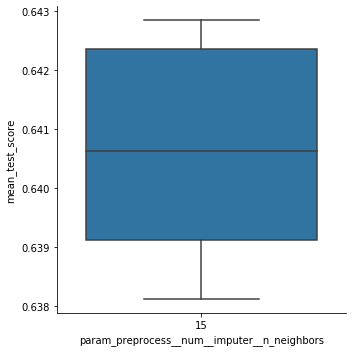

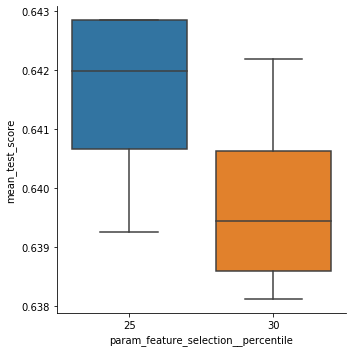

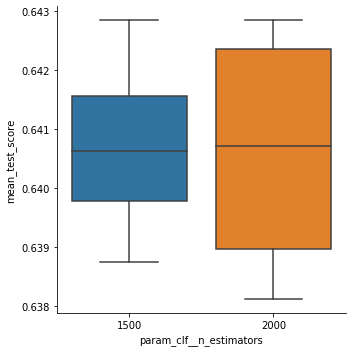

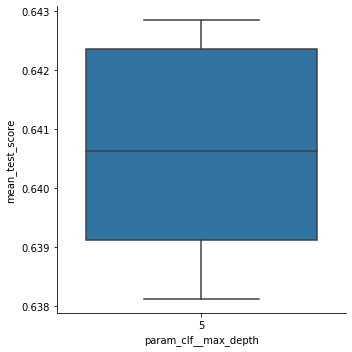

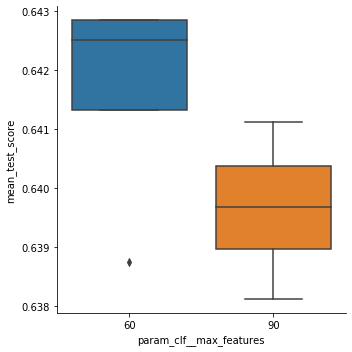

In [66]:
# create results data frame
results = pd.DataFrame.from_dict(cv.cv_results_)
results.drop(columns=[c for c in results.columns if ('time' in c) | ('split' in c)], inplace=True)

# print validation performance --------------------------------------
print('Best Hyper Parametrs', end='\n\n')
for k, v in cv.best_params_.items():
    print(k, v, sep=':')

print(f'\n\nBest validation model macro avg F1: {cv.best_score_}')

# print test performance ------------------------------------------
msk = np.random.choice([True, False], len(x_test), p=[.02, .98])
y_hat_test = cv.best_estimator_.predict(x_test[msk])

print('\nConfusion Matrix\nActual v Predicted (test set)', 
      pd.DataFrame(confusion_matrix(y_true=y_test[msk], y_pred=y_hat_test), 
                   index=['no', 'yes'], columns=['no', 'yes']), 
      sep='\n')

print('\nTest Set Classification Report',
      classification_report(y_true=y_test[msk], y_pred=y_hat_test), sep='\n')

test_auc = roc_auc_score(y_test[msk] == 1, y_hat_test == 1)
print(f'Test roc auc: {np.round(test_auc, 3)}')

# review hyper param selection's impact on performance
for p in param_grid[0].keys():
    sns.catplot('param_' + p, 'mean_test_score', data=results, kind='box')

In [79]:
def system_entropy_given_col(col, y):
    """
    Calculate system entropy after splitting on categories in column 'col'
    :param col: np.array of column with categories
    :param y: np.array of column with data we are using to check entropy
    """
    # get levels and counts of obs in each level
    lvl, n = np.unique(col, return_counts=True)
    
    # calculate entropy for each level, after splitting
    e = []
    for l, ln in zip(lvl, n):
        y_lvls, y_counts = np.unique(y[col == l], return_counts=True)

        e.append(entropy(y_counts / y_counts.sum()))
    
    # calculate weighted avg entropy
    return np.average(e, weights=n)

system_entropy_given_col(col, y)

0.5393367728406329

In [ ]:
df_num = df._get_numeric_data()
col_corr_cols = []
col_corr = []
for c in df_num.columns:
    if c == 'target':
        continue
    
    this_cor = np.corrcoef(df_num[c], df_num.target)[0][1]
    
    if np.isnan(this_cor):
        continue
    else:
        col_corr_cols.append(c)
        col_corr.append(this_cor)
        
col_corr = np.array(col_corr)

fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(col_corr, bins=50)
plt.show()

In [41]:
col_corr

array([-0.07687555,  0.00101452,  0.07665814, ...,  0.11862721,
        0.0281678 ,  0.00778034])

In [ ]:
col_types = df.dtypes.reset_index()
col_types.columns = ['column', 'dtype']
col_types.loc[0, 'dtype'].isnumeric()
# for c, d in col_types.itter_rows():
#     if d != 'object':
#         print(c)

In [50]:
yp = np.array([0, 0, 0, 1, 1])
yt = np.array([0, 0, 0, 0, 1])

log_loss(yp, yt)

6.907755278982137

array([1, 2])

In [ ]:
# targetd clients
msk = p >= .9

# add zero probability obs to end so that the color scale is the same
x_filtered = p[idx_shuffled][msk]
x_filtered = np.concatenate((np.array([9]), x_filtered))

y_filtered = y_loc[msk]
y_filtered = np.concatenate((np.array([9]), y_filtered))

p_filtered = p[msk]
p_filtered = np.concatenate((np.array([0]), p_filtered))

fig, ax = plt.subplots(figsize=(9, 9))
plt.scatter(x_filtered, y_filtered, c=p_filtered, cmap='Greys')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.xlim(-.01, 1.01)
plt.ylim(-.01, 1.01)
plt.title('Optimized marketing campaign targets')
plt.show()


# results
msk = p >= .9

# add zero probability obs to end so that the color scale is the same
x_filtered = p[idx_shuffled][msk]
x_filtered = np.concatenate((np.array([9]), x_filtered))

y_filtered = y_loc[msk]
y_filtered = np.concatenate((np.array([9]), y_filtered))

p_filtered = np.random.choice((0, 1), len(y_filtered) -1, replace=True, p=(.2, .8))
p_filtered = np.concatenate((np.array([0]), p_filtered))

fig, ax = plt.subplots(figsize=(9, 9))
# idx_random = np.random.choice()
msk = p_filtered == 0
plt.scatter(x_filtered[msk], y_filtered[msk], color='C0', label='not converted')
plt.scatter(x_filtered[~msk], y_filtered[~msk], color='C1', label='converted')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.xlim(-.01, 1.01)
plt.ylim(-.01, 1.01)
plt.legend()
plt.title('Optimized marketing campaign results')
plt.show()

In [ ]:
df_num = df._get_numeric_data()
val_counts = []
for c in df_num.columns:
    val_counts.append(len(df_num[c].value_counts()))

val_counts = np.array(val_counts)
msk = val_counts <= 50
plt.hist(val_counts[msk])

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  7., 11.]),
 array([0.08641406, 0.17713918, 0.2678643 , 0.35858942, 0.44931454,
        0.54003966, 0.63076478, 0.7214899 , 0.81221502, 0.90294014,
        0.99366526]),
 <a list of 10 Patch objects>)

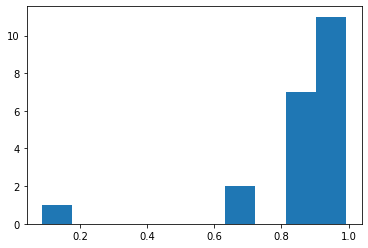

In [109]:
nas = []
for c in num_cols:
    nas.append(df[c].isna().sum() / len(df))
nas = np.array(nas)
plt.hist(nas[(nas > 0.01) & (nas < 1)])